### Emma Klemets, 260775167   
All my work, code, output and written answers for **Q2 & Q3** are in this notebook.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import wmap_camb_example

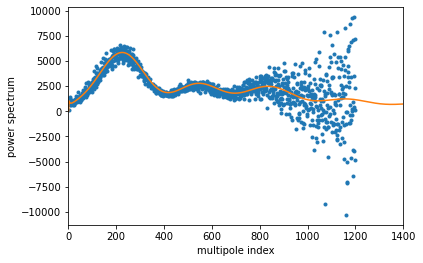

In [24]:
#given code
plt.ion()

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

#[multipole index, measured power spectrum, error, instrument noise part, “cosmic variance” part]
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
# plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*', alpha=0.1)
plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb=wmap_camb_example.get_spectrum(pars)

plt.xlim(0, 1400)
plt.plot(cmb)
plt.xlabel("multipole index")
plt.ylabel("power spectrum")

plt.show()

### 2) 
Using Gaussian, uncorrelated errors, what do you get for χ2 for the model in my example script, where the Hubble constant H_0 = 65 km/s, the physical baryon density $ω_bh^2=0.02$, the cold dark matter density $ω_ch^2 = 0.1$ the optical depth $τ = 0.05$, the primordial amplitude of fluctuations is $A_s = 2 × 10^{−9}$, and the slope of the primordial power law is 0.96 (where 1 would be scale-invariant). The baryon/dark matter densities are defined relative to the critical density required to close the universe, scaled by h^2 where $h ≡ H_0/100 ∼ 0.7$.   
Note that the universe is assumed to be spatially flat (for reasons too long to justify here), so the dark matter density relative to critical for these parameters would be $1 − (ω_bh^2 + ω_ch^2)/h^2 =71.6%$ for the model assumed here. (You may want to play around plotting different models as you change parameters to get a sense for how the CMB depends on them.)   
If everything has gone well, you should get something around 1588 (please give a few extra digits) for χ2 for this model.

In [38]:
variables = ['H_0', 'w_b h^2', 'w_c h^2', 'tau', 'A_s', 'slope']

#calculates chi^2
def chisq(data,pars):
    x=data[0]
    y=data[1]
    noise=data[2]
    
    #enforce prior - set chi to inf if tau is negative to not get these terms
    if pars[3] < 0:
        chisq = np.inf
    else:
        model=cmbfun(x,pars)

        chisq=np.sum( (y-model)**2/noise**2)
    
    return chisq

#call the cmb function with the current parameters
def cmbfun(x,pars):
    y = wmap_camb_example.get_spectrum(pars)[2:len(x)+2]
    return y

#simply plots the data and the fitted function for given parameters
def plotResults(pars_fitted):

    plt.plot(wmap[:,0],wmap[:,1],'.') 

    cmb=wmap_camb_example.get_spectrum(pars_fitted)

    plt.plot(cmb) #what really is the x values here then?
    plt.xlabel("multipole index")
    plt.ylabel("power spectrum")
    plt.xlim(0, 1400)

    plt.show()
    
#print out results with errors
def printResults(params, errs):
    if len(params) == 5:
        arr = [0, 1, 2, 4, 5]
    elif len(params) == 1:
        arr = [3]
    else:
        arr = [i for i in range(6)]
    
    for i, ele in enumerate(arr):
        print("{}: {:.4} +/- {:.2}".format(variables[ele], params[i], errs[i]))

In [5]:
#chi: sum( (data - fitted)^2/sigma^2 )

#assuming Gaussian, uncorrelated errors --> N is diagonal and sigma_i is simplly the error on each value

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
cmb=wmap_camb_example.get_spectrum(pars)

chiSq = 0

for i in range(0, len(wmap)):
    
    chiSq += (wmap[i,1]-cmb[i+2])**2 / wmap[i,2]**2

print("Chi squared is: {}".format(chiSq))

Chi squared is: 1588.2376532931519


### 3) 
Keeping the optical depth fixed at 0.05, write a Newton’s method/LevenbergMarquardt minimizer and use it to find the best-fit values for the other parameters, and their errors. What are they?   
Note that CAMB does not provide derivatives with respect to parameters, so you’ll have to come up with something for that. *Please also provide a plot showing why we should believe your derivative estimates.*

In [18]:
#numerical derivative, taking a couple points
def derive_long(x, params, i, Min, Max, steps):

    fitP = params[i]

    var = np.linspace(fitP - Min , fitP + Max, steps)

    smaller = np.where(var < fitP)[0][-1]
    bigger = np.where(var > fitP)[0][0]
        
    paramArr = [ np.where(params==fitP, v, params) for v in var]

    #quite slow - this is not going to be efficent
    y = np.array([wmap_camb_example.get_spectrum(p, 1820)[2:] for p in paramArr])
    
    slope = [(y[bigger,int(j)] - y[smaller,int(j)]) / (var[bigger] - var[smaller]) for j in x]
    
    chiArr = []
    for run in y:
        chiSq = 0

        for i in range(0, len(wmap)):
            chiSq += (wmap[i,1]-run[i+2])**2 / wmap[i,2]**2
            
        chiArr.append(chiSq)

    return [slope, y, var, chiArr]

#numerical derivative using just two points for 'speed'
def derive_short(x, params, i, stepSize):

    fitP = params[i]

    x1 = fitP + stepSize
    x2 = fitP - stepSize
       
    paramArr1 = np.where(params==fitP, x1, params)
    paramArr2 = np.where(params==fitP, x2, params)

    y1 = wmap_camb_example.get_spectrum(paramArr1, 1820)[2:]
    y2 = wmap_camb_example.get_spectrum(paramArr2, 1820)[2:]
    
    slope = [(y1[int(j)] - y2[int(j)]) / (x1 - x2) for j in x]

    return [slope]

#### Checking derivatives

In [8]:
pars_guess=np.asarray([65, 0.02, 0.1, 0.05, 2e-9, 0.96])

x=wmap[:,0]

# results = derive_long(x, pars_guess, 0, 10, 10, 8)
# results = derive_long(x, pars_guess, 1, 0.001, 0.001, 8)
# results = derive_long(x, pars_guess, 2, 0.05, 0.05, 8)
# results = derive_long(x, pars_guess, 3, 0.005, 0.005, 8)
# results = derive_long(x, pars_guess, 4 ,1e-9, 1e-9, 8)
results = derive_long(x, pars_guess, 5, 0.5, 0.5, 8)

slope = results[0]
y = results[1]
var = results[2]
chi_vals = results[3]

In [57]:
x=wmap[:,0]

# results_short = derive_short(x, pars_guess, 0, 4)[0]
# results_short = derive_short(x, pars_guess, 1, 0.001/2.0)[0]
# results_short = derive_short(x, pars_guess, 2, 0.05/2.0)[0]
# results_short = derive_short(x, pars_guess, 3, 0.005)[0]
# results_short = derive_short(x, pars_guess, 4, 1e-9/2.0)[0]
results_short = derive_short(x, pars_guess, 5, 0.5/2.0)[0]


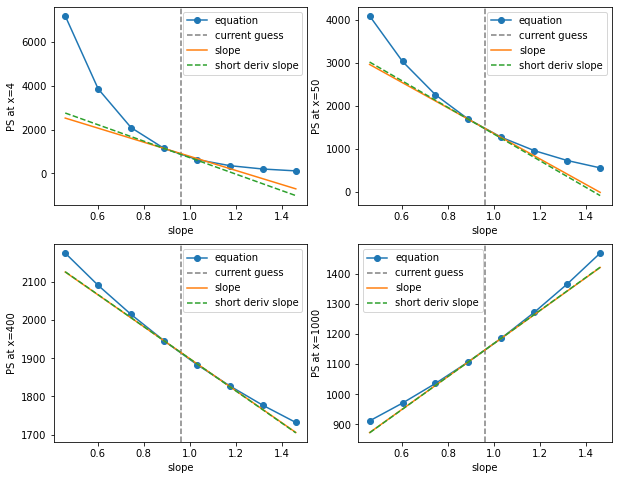

In [58]:
p = 5

fig, ax = plt.subplots(2, 2, figsize=(10,8))

axs = ax.flatten()
current = pars_guess[p]

for i, x in enumerate([4, 50, 400, 1000]):

    #mx + b
    b = y[3,x] - slope[x]*var[3]
    b_short = y[3,x] - results_short[x]*var[3]

    #dep on x value
    axs[i].plot(var, y[:,x], label='equation', marker="o")
    axs[i].set_xlabel(variables[p])
    axs[i].set_ylabel("PS at x={}".format(x))
    axs[i].axvline(current, color='grey', ls="--", label="current guess")
    axs[i].plot(var, slope[x]*var + b, label='slope')
    axs[i].plot(var, results_short[x]*var + b_short, label='short deriv slope', ls="--")

    axs[i].legend()

plt.show()

In [19]:
#plots chi sqaured for small changes of one variable at a time
def lookAtChi(pars_guess, step, title):
    x=wmap[:,0]

    fig, ax = plt.subplots(2, 3, figsize=(12,9))
    axs = ax.flatten()


    for i in range(0, 6):
        results = derive_long(x, pars_guess, i, step[i], step[i], 8)

        chi_vals = results[3]

        var = results[2]
        chi_vals = results[3]

        axs[i].plot(var, chi_vals)
        axs[i].axvline(pars_guess[i], color='grey', ls="--", label="current guess")
        axs[i].set_ylabel("$\chi^2$")
        axs[i].set_xlabel(variables[i])

    fig.suptitle(title)
    plt.show()

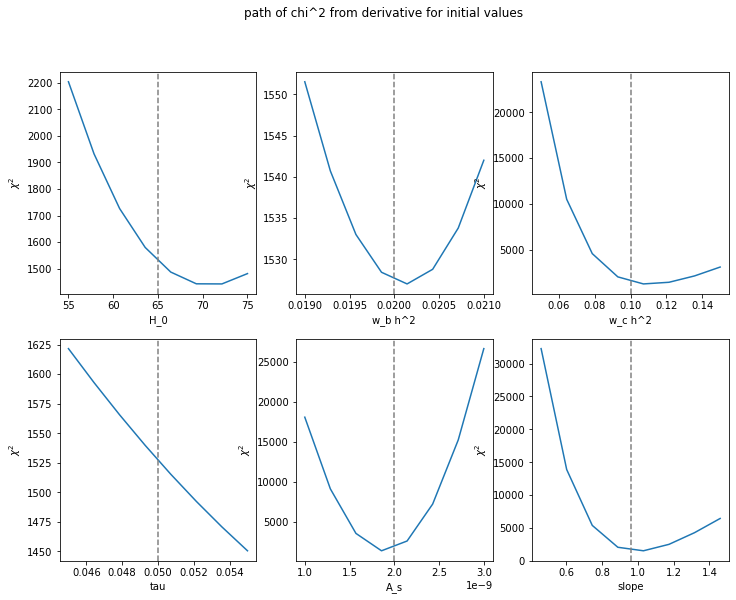

In [59]:
pars_guess=np.asarray([65, 0.02, 0.1, 0.05, 2e-9, 0.96])
step = [10, .001, 0.05, 0.005, 1e-9, 0.5]

title = "path of chi^2 from derivative for initial values"
lookAtChi(pars_guess, step, title)

Looking at the derivatives of each paramter (with the others fixed), which can all be found in "derivative_checks.pdf", these numerical derivatives seem well behaved for the given step size and can be used safely. I also looked at the $\chi^2$, it looks fairly smooth for these step sizes. I can already see that tau behaves differently than the others, where for the fixed other values, most of the parameters have a minimum for $\chi^2$ quite close by, but tau does not.

#### Newton's Method time

In [20]:
#function and derivatives
#the value of fitVals sets if this fit is for the 5 parameters, just tau, or all
def f_cmb(x, params, fitVals='all', fixVals=[]):
    
    derivs=np.zeros([len(x),len(params)])
        
    if fitVals=='5':
        params = np.insert(params, 2, fixVals)
       
    elif fitVals=='tau':
        params = np.insert(fixVals, 3, params)
    
    y = wmap_camb_example.get_spectrum(params, lmax=len(x))[:-2]
    
    if fitVals=='5':
        derivs[:,0]=derive_short(x, params, 0, 4)[0]
        derivs[:,1]=derive_short(x, params, 1, 0.001/2.0)[0]
        derivs[:,2]=derive_short(x, params, 2, 0.05/2.0)[0]
        derivs[:,3]=derive_short(x, params, 4, 1e-9/2.0)[0]
        derivs[:,4]=derive_short(x, params, 5, 0.5/2.0)[0]
        
    elif fitVals=='tau':
        if params[3] < 0: #don't want negative tau
            derivs[:,0] = 10000*np.ones(len(x))
            print("n")
        else:
            derivs[:,0]=derive_short(x, params, 3, 0.005)[0]
    else:
    
        derivs[:,0]=derive_short(x, params, 0, 4)[0]
        derivs[:,1]=derive_short(x, params, 1, 0.001/2.0)[0]
        derivs[:,2]=derive_short(x, params, 2, 0.05/2.0)[0]

        if params[3] < 0:
            derivs[:,3] = 10000*np.ones(len(x))
            print("negative")
        else:
            derivs[:,3]=derive_short(x, params, 3, 0.005)[0]

        derivs[:,4]=derive_short(x, params, 4, 1e-9/2.0)[0]
        derivs[:,5]=derive_short(x, params, 5, 0.5/2.0)[0]
    
    return y,derivs


In [25]:
#set up for the fitting
sig=wmap[:,2]
y=wmap[:,1]
Ninv=np.eye(len(y))/sig**2

# newton's method with Levenberg-Marquardt
def NM_withLM(x, guesses, steps, fitVals='all', fixVals=[]):
    pars_guess=np.asarray(guesses)

    pars_cur=pars_guess.copy()

    pars_savedArr = []
    Lambda = 0
    
    if fitVals=='5':
        chi_pars = np.insert(pars_cur, 2, fixVals)
    elif fitVals=='tau':
        chi_pars = np.insert(fixVals, 3, pars_cur)
    else:
        chi_pars = pars_cur
            
    prev_chi = chisq([x, y, sig], chi_pars)

    for iter in range(steps):
        y_pred,derivs=f_cmb(x,pars_cur, fitVals=fitVals,fixVals=fixVals)
        resid=y-y_pred #data minus current model

        rhs=derivs.T@(Ninv@resid)
        lhs=derivs.T@Ninv@derivs

        #rescale this on diagonal
        for i in range(len(lhs[0])):
            lhs[i][i] = (1+Lambda)*lhs[i][i]

        #get the step to take
        step=np.linalg.inv(lhs)@rhs

        if fitVals=='5':
            chi_pars = np.insert(pars_cur+step, 2, fixVals)
        elif fitVals=='tau':
            chi_pars = np.insert(fixVals, 3, pars_cur+step)
        else:
            chi_pars = pars_cur + step
            
        chi = chisq([x, y, sig], chi_pars)

        #chiSq improves, take step
        if chi < prev_chi:
            pars_cur = pars_cur+step
            pars_savedArr.append(pars_cur) #save values for corvarience matrix
            Lambda = Lambda / np.sqrt(2) #make lambda step smaller
            print('iteration ',iter,' has step ',step)
#             print(pars_cur)
            
            #if the new model doesn't improve chi squared significantly, stop interating
            if np.abs(chi - prev_chi) < 0.1 and Lambda < 5:
                print("Small chi square change")
                break

        #chiSq doesn't improves, increase lambda
        else:
            if Lambda == 0:
                Lambda = 2
            else:
                Lambda = 2*Lambda
    #             pars_cur = pars_cur+step
            print('iteration ',iter, 'has step ',step, 'and increase lambda to ',Lambda)

        prev_chi = chi #save new chisquared for next step

        print("chisq: ", chi)

    par_errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
    if fitVals=='tau':
        cov = []
    else:#saving covarience matrix for later
        cov = np.linalg.inv(lhs)
    
    return [pars_cur, par_errs, pars_savedArr, cov]

In [26]:
pars_guess=np.asarray([65, 0.02, 0.1, 2e-9, 0.96])
x=wmap[:,0]

#fitting the 5 parameters without tau
fit5results = NM_withLM(x, pars_guess, 18, fitVals='5', fixVals=[0.05])

#print results
print()
printResults(fit5results[0], fit5results[1])

pars_fitted=np.insert(fit5results[0], 2, 0.05)

cov_5 = fit5results[3]

iteration  0  has step  [ 3.56898189e+01 -4.84323847e-03 -2.07662342e-02 -7.42398037e-10
 -9.23726936e-03]
chisq:  3860.973221046705
iteration  1  has step  [-3.67977850e+00  9.38978722e-03  8.40111790e-03  4.24915353e-10
  7.21641240e-02]
chisq:  1813.6332131646666
iteration  2 has step  [-1.80192123e+01 -4.45970142e-03  2.57512657e-02  1.95248591e-10
 -5.83902679e-02] and increase lambda to  2
chisq:  5204.4452428472105
iteration  3  has step  [ 3.26406790e+00 -1.25371014e-03  1.42571739e-03 -1.02530281e-11
  6.25319400e-03]
chisq:  1531.872738961895
iteration  4  has step  [ 2.70254845e+00 -7.53498174e-04  1.09501968e-03 -4.23040417e-12
  1.83143884e-03]
chisq:  1444.1945900127168
iteration  5  has step  [ 1.96975908e+00 -3.30703144e-04  8.56774796e-04 -6.08296363e-13
 -4.71244371e-04]
chisq:  1425.8318302705593
iteration  6  has step  [ 1.25148956e+00 -6.29552825e-05  7.42663065e-04  1.52580395e-12
 -8.60257522e-04]
chisq:  1425.7275926369134
iteration  7 has step  [ 6.75754741e-01

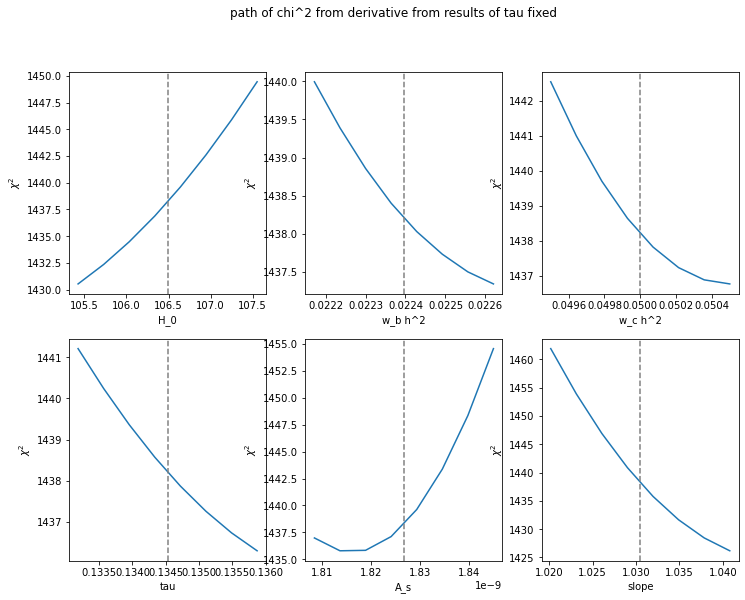

In [48]:
step = pars_fitted/100

title = "path of chi^2 from derivative from results of tau fixed"
lookAtChi(pars_fitted, step, title)

*If you were to keep the same set of parameter but now float τ, what would you expect the new errors to be?*   
Already seen above Tau seems to be very correlated to the other parameters, so I expect that changing tau while holding the other parameters constant would make the errors worse. We have less degrees of freedom to move, as well as the prior that tau must be non negative, which my Newton's method keeps running in that direction. I have made a catch for this so that chi^2 is infinite when this occurs, but it still does not give great results.

In [34]:
#fitting just for tau while holding other values fixed
tau_guess = [0.05]
fitTau_results = NM_withLM(x, tau_guess, 25, fitVals='tau', fixVals=fit5results[0])

print()
printResults(fitTau_results[0], fitTau_results[1])

iteration  0 has step  [-0.08339361] and increase lambda to  2
chisq:  inf
iteration  1  has step  [-0.02779787]
chisq:  3255.033346258763
iteration  2  has step  [-0.02146391]
chisq:  2809.2875931095277
iteration  3 has step  [-0.02455497] and increase lambda to  1.9999999999999998
chisq:  inf
iteration  4 has step  [-0.01636998] and increase lambda to  3.9999999999999996
chisq:  inf
iteration  5 has step  [-0.00982199] and increase lambda to  7.999999999999999
chisq:  inf
iteration  6 has step  [-0.00545666] and increase lambda to  15.999999999999998
chisq:  inf
iteration  7 has step  [-0.00288882] and increase lambda to  31.999999999999996
chisq:  inf
iteration  8 has step  [-0.00148818] and increase lambda to  63.99999999999999
chisq:  inf
iteration  9 has step  [-0.00075554] and increase lambda to  127.99999999999999
chisq:  inf
iteration  10  has step  [-0.0003807]
chisq:  2809.2875931095277
iteration  11 has step  [-0.00057474] and increase lambda to  181.01933598375612
chisq:  

In [35]:
#fitting just for tau while holding other values fixed at orginal given guess, 
#as the first run doesn't have very good results, this does seem to give a better tau value
pars_guess=np.asarray([65, 0.02, 0.1, 2e-9, 0.96])
tau_guess = [0.05]
fitTau_results = NM_withLM(x, tau_guess, 25, fitVals='tau', fixVals=pars_guess)

print()
printResults(fitTau_results[0], fitTau_results[1])

iteration  0  has step  [0.02758363]
chisq:  1349.267548246437
iteration  1 has step  [0.0008207] and increase lambda to  2
chisq:  1349.4256304360968
iteration  2  has step  [0.00027357]
chisq:  1349.2762516612456
iteration  3 has step  [0.00022673] and increase lambda to  2.82842712474619
chisq:  1349.3168305278136
iteration  4  has step  [0.00014298]
Small chi square change

tau: 0.078 +/- 0.00094


In [39]:
#fitting all 6 parameters, mainly to get covarience matrix out, and hopefully results to start the MCMC at

pars_guess=np.asarray([65, 0.02, 0.1, 0.05, 2e-9, 0.96])
# pars_fitted #usually should the results of the first 5 parameter run, but using the original 
# guess gives much better results

print("start with", pars_guess)

fitAll_results = NM_withLM(x, pars_guess, 20, fitVals='all')
print()
printResults(fitAll_results[0], fitAll_results[1])

start with [6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]
iteration  0  has step  [5.24839352e+00 2.66146710e-03 1.38230045e-02 1.44514583e-01
 6.34813412e-10 1.02033077e-02]
chisq:  1309.496207428477
iteration  1  has step  [ 8.95003211e+00  1.55375149e-03 -1.37950227e-02  8.22985299e-02
  4.41493172e-10  6.06827806e-02]
chisq:  1251.6240146940204
iteration  2 has step  [-1.99373275e+01 -4.34749953e-03  2.93358423e-02 -3.04202428e-01
 -1.63863462e-09 -1.49162058e-01] and increase lambda to  2
chisq:  inf
iteration  3  has step  [ 2.31950217e-02 -3.12630742e-05 -3.24940274e-04 -1.25872397e-03
  7.14932103e-12 -1.04060058e-03]
chisq:  1242.270176392818
iteration  4  has step  [ 8.84775555e-02 -2.97167907e-05 -1.19417818e-04 -6.93916010e-04
  3.68967720e-12  4.78206679e-05]
chisq:  1240.7458651555128
iteration  5  has step  [ 9.56765183e-02 -8.79037154e-06 -2.32502038e-05 -4.12248512e-04
  1.88975252e-12  5.82851036e-04]
Small chi square change

H_0: 79.41 +/- 0.55
w_b h^2: 0.02415 +/

In [40]:
chi = chisq([x, y, sig], fitAll_results[0])
print("Chi squared/DOF = ", chi/len(x)) #this is pretty good

#save corvariance matrix for sample for MCMC
cov = fitAll_results[3]

cov #for the MCMC

Chi squared/DOF =  1.0348046747749575


array([[ 3.03437526e-01,  2.88692599e-05, -8.52825259e-05,
        -1.62274841e-05,  4.58660410e-14,  2.61727721e-04],
       [ 2.88692599e-05,  3.74275141e-08,  7.41685997e-09,
        -2.27803931e-08,  1.32060061e-16,  1.92002848e-07],
       [-8.52825259e-05,  7.41685997e-09,  3.66439436e-07,
        -2.57645586e-07,  1.49431865e-15, -2.94419107e-07],
       [-1.62274841e-05, -2.27803931e-08, -2.57645586e-07,
         2.66991796e-06,  5.36293890e-15, -8.93517788e-07],
       [ 4.58660410e-14,  1.32060061e-16,  1.49431865e-15,
         5.36293890e-15,  9.60675754e-23,  6.78532356e-15],
       [ 2.61727721e-04,  1.92002848e-07, -2.94419107e-07,
        -8.93517788e-07,  6.78532356e-15,  1.43225066e-05]])

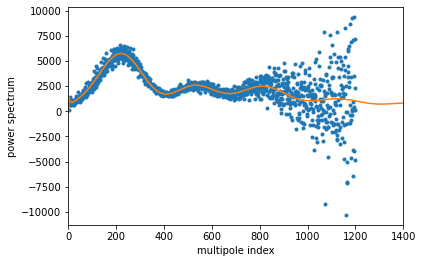

In [41]:
#plot to see how the 6 fitted parameters look

plotResults(fitAll_results[0])